Libraries imported.


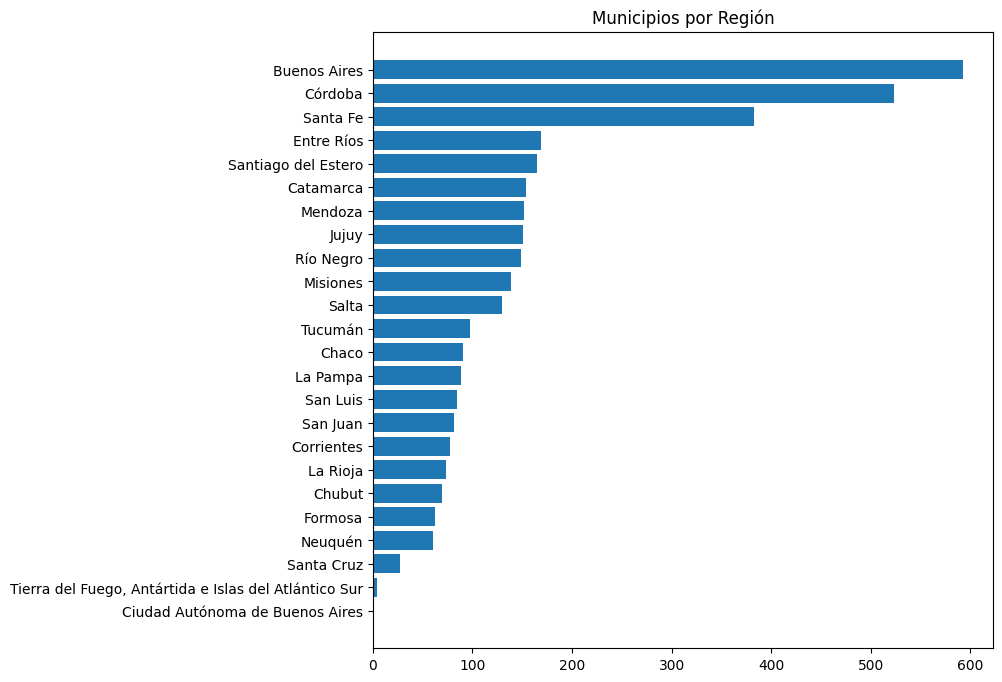

In [4]:


import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import json


from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors


from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import folium

print('Libraries imported.')
import wget

url="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.29/download/localidades-censales.csv"
path="D:/Users/Usuario/Documents/python 2021/"
wget.download(url,path)
url_prov="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.7/download/provincias.csv"
wget.download(url_prov,path)
url_internet="http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/CONEC-AL-SERVI-DE-INTER/data.csv?auth_key=44a38fbffd39c9f7d84e8e7dd2e1d02f0950e611&download=1/"
wget.download(url_internet,path)

localidades=pd.read_csv("localidades-censales.csv")
internet=pd.read_csv("ConectividadalserviciodeInternet_2776151683551485030.csv")
provincias=pd.read_csv(path+"provincias.csv")
regiones=pd.DataFrame(localidades.groupby(["provincia_nombre"]).size(),columns=['municipios']).sort_values(by="municipios")


fig, ax = plt.subplots()


fig.set_size_inches(8,8)


ax.barh(y=regiones.index, width=regiones.municipios);


ax.set_title('Municipios por Región');

In [5]:
regiones["Provincias"]=regiones.index

geo_prov=regiones.merge(provincias,left_on="Provincias",right_on="nombre")

In [6]:

url_map="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.12/download/provincias.geojson"
filename=wget.download(url_map)

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [7]:
costa_atlan=geo_prov.loc[[1,2,5,15,23]]
costa_atlan=costa_atlan.drop(["categoria","nombre","fuente","id","iso_id","nombre_completo","Provincias"],axis=1)

In [8]:
costa_atlan.reset_index(drop=True,inplace=True)
costa_atlan.rename(columns={"iso_nombre": "Provincia", "B": "c"},inplace=True)

In [11]:
address = 'Argentina'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('las coordenadas son {}, {}.'.format(latitude, longitude))

las coordenadas son -34.9964963, -64.9672817.


In [12]:

map_costa = folium.Map(location=[latitude, longitude], zoom_start=4)


for lat, lng, label in zip(costa_atlan['centroide_lat'], costa_atlan['centroide_lon'], costa_atlan['Provincia']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_costa)  
    
map_costa

De estas 4 provincias, se seleccionarán las localidades con acceso al mar e infraestructura para disfrutar de las playas, recibir nuevos pobladores.

In [13]:
costa_atlan

,municipios,centroide_lat,centroide_lon,Provincia
0,4,-82.521518,-50.742749,Tierra del Fuego
1,27,-48.815485,-69.955762,Santa Cruz
2,69,-43.788623,-68.526759,Chubut
3,149,-40.405796,-67.229330,Río Negro
4,593,-36.676942,-60.558832,Buenos Aires


In [32]:

loc_costa=pd.read_csv("D:/Users/Usuario/Documents/python 2021/Localidades_Costa1.txt", encoding='latin-1')



In [35]:

costa_limpio=pd.DataFrame(data=loc_costa["Ciudad"].str.strip())



In [37]:

costa_merge=localidades.merge(costa_limpio,left_on='nombre',right_on='Ciudad')

print("Localidades de la Costa",costa_limpio.shape)
print("Merge con el Repositorio",costa_merge.shape)

Localidades de la Costa (10, 1)
Merge con el Repositorio (11, 14)


In [38]:
#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
costa_data=costa_merge[(costa_merge["provincia_nombre"]=="Buenos Aires")|
            (costa_merge["provincia_nombre"]=="Chubut")|
            (costa_merge["provincia_nombre"]=="Santa Cruz")|
            (costa_merge["provincia_nombre"]=="Río Negro")|
            (costa_merge["provincia_nombre"]=="Tierra del Fuego, Antártida e Islas del Atlántico Sur")
            ]

### Variables Geográficas

#### Obtención de variables por medio del servicio de Foursquare
A continuación vamos a empezar a utilizar el API de FourSquare para explorar las localidades y segmentarlos, por medio de una función que los explore todos.

In [39]:
CLIENT_ID = 'LM5HN3042JGPC50VLXUT2XG4L1Z4BN3DY1S5MBA5ANSVO54V' # su ID de Foursquare
CLIENT_SECRET = 'YCBLJNJX2WJMP0CKANFLTPXGSAQIARRGUKPB5BRROGAWPJO3' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LM5HN3042JGPC50VLXUT2XG4L1Z4BN3DY1S5MBA5ANSVO54V
CLIENT_SECRET:YCBLJNJX2WJMP0CKANFLTPXGSAQIARRGUKPB5BRROGAWPJO3


In [40]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

De la función se obtienen todas las calles de las ciudades de la costa

In [41]:
cos_venues = getNearbyVenues(names=costa_data['nombre'],
                                   latitudes=costa_data['centroide_lat'],
                                   longitudes=costa_data['centroide_lon']
                                  )

Bahía Blanca
Punta Alta
Miramar
Mar del Plata
Villa Gesell
Puerto Madryn
Comodoro Rivadavia
Río Grande
Caleta Olivia


In [42]:
cos_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bahía Blanca,9,9,9,9,9,9
Caleta Olivia,4,4,4,4,4,4
Comodoro Rivadavia,2,2,2,2,2,2
Mar del Plata,61,61,61,61,61,61
Miramar,23,23,23,23,23,23
Puerto Madryn,2,2,2,2,2,2
Punta Alta,4,4,4,4,4,4
Río Grande,4,4,4,4,4,4
Villa Gesell,5,5,5,5,5,5


In [43]:
print('Hay {} categorias únicas.'.format(len(cos_venues['Venue Category'].unique())))

Hay 56 categorias únicas.


#### Normalización de Variables

Ahora se prepara el dataset para poder aplicar el modelo de segmentación. Para esto las variables categóricas se pasan a Dummies (1 o 0) y las numéricas se llevan al mismo rango. A este proceso se llama normalización de variables o codificación.

In [44]:
# codificación
costa_onehot = pd.get_dummies(cos_venues[['Venue Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
costa_onehot['Neighbourhood'] = cos_venues['Neighbourhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [costa_onehot.columns[-1]] + list(costa_onehot.columns[:-1])
costa_onehot = costa_onehot[fixed_columns]

#Agrupación por el promedio
costa_grouped = costa_onehot.groupby('Neighbourhood').mean().reset_index()

In [45]:

costa_grouped.head()

,Neighbourhood,Arcade,Argentinian Restaurant,BBQ Joint,Bar,Bed & Breakfast,Beer Bar,Bookstore,Bowling Alley,Breakfast Spot,...,Restaurant,Salad Place,Seafood Restaurant,Shopping Mall,Skating Rink,Snack Place,Sporting Goods Shop,Supermarket,Theater,Video Store
0,Bahía Blanca,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,Caleta Olivia,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Comodoro Rivadavia,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0
3,Mar del Plata,0.016393,0.065574,0.0,0.016393,0.016393,0.0,0.016393,0.0,0.000000,...,0.081967,0.016393,0.000000,0.016393,0.016393,0.032787,0.016393,0.016393,0.032787,0.0
4,Miramar,0.043478,0.043478,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.130435,...,0.000000,0.000000,0.043478,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.0


Ahora se van a seleccionar los 3 sitios mas comunes de cada localidad. Primero por medio de una función se ordenan los sitios en orden descendente.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Se genera el nuevo dataframe y con los 3 sitios mas populares de cada localidad.

In [47]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = costa_grouped['Neighbourhood']

for ind in np.arange(costa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(costa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bahía Blanca,Café,Gastropub,Coffee Shop
1,Caleta Olivia,Hot Dog Joint,Park,Candy Store
2,Comodoro Rivadavia,Pharmacy,Supermarket,Pedestrian Plaza
3,Mar del Plata,Café,Restaurant,Pizza Place
4,Miramar,Pizza Place,Café,Breakfast Spot


### Variables de Telecomunicaciones

A las variables encontradas de categoría de sitios populares, se van a sumar las relacionadas con los servicios de telecomunicaciones. Que detalla las tecnologías disponibles en cada localidad para acceder al servicio de Internet fijo y móvil.



In [48]:
##Sumar variables de Internet
acceso=internet.drop(["Partido","link","Latitud","Longitud"],axis=1)

#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
int_var=acceso[(acceso["Provincia"]=="BUENOS AIRES")|
            (acceso["Provincia"]=="CHUBUT")|
            (acceso["Provincia"]=="SANTA CRUZ")|
            (acceso["Provincia"]=="RIO NEGRO")|
            (acceso["Provincia"]=="TIERRA DEL FUEGO")
            ]

In [49]:
#Se hace un merge para trabajar solo con las localidades en estudio
variables_data=costa_grouped[["Neighbourhood"]].merge(int_var,how="left",left_on="Neighbourhood",right_on="Localidad")

In [50]:
variables_data.columns

Index(['Neighbourhood', 'Provincia', 'Localidad', 'Poblacion', 'ADSL',
       'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS',
       'TELEFONIAFIJA', '3G', '4G'],
      dtype='object')

In [51]:
variables_data.head()

,Neighbourhood,Provincia,Localidad,Poblacion,ADSL,CABLEMODEM,DIALUP,FIBRAOPTICA,SATELITAL,WIRELESS,TELEFONIAFIJA,3G,4G
0,Bahía Blanca,BUENOS AIRES,Bahía Blanca,291327.0,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,Caleta Olivia,SANTA CRUZ,Caleta Olivia,51733.0,--,SI,--,SI,SI,SI,--,SI,SI
2,Comodoro Rivadavia,CHUBUT,Comodoro Rivadavia,175196.0,SI,SI,SI,SI,SI,SI,SI,SI,SI
3,Mar del Plata,BUENOS AIRES,Mar del Plata,560913.0,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,Miramar,BUENOS AIRES,Miramar,29433.0,SI,SI,SI,SI,SI,SI,SI,SI,SI


De estas 4 provincias, se seleccionarán las localidades con acceso al mar e infraestructura para disfrutar de las playas, recibir nuevos pobladores.

Se deben normalizar las variables de conexión de Internet para que sean intrepretadas correctamente por el modelo. Para esto se convierte las variables alfanumericas correspondientes a los tipos de conexión a 0 y 1.

In [52]:
# example of a ordinal encoding
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
#define data
data = variables_data[['ADSL','CABLEMODEM','DIALUP','FIBRAOPTICA','SATELITAL','WIRELESS', 'TELEFONIAFIJA','3G','4G']]
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
result = encoder.fit_transform(data)

Convertir de nuevo a un dataframe y unirlo a las variables geográficas ya normalizadas

In [53]:
#Convertir a un dataframe
internet_grouped=pd.DataFrame(data=result,columns=[data.columns]).reset_index(drop=True)

#Concatenar con las variables geograficas
var_grouped=pd.concat([costa_grouped,internet_grouped], axis=1)


In [54]:
internet_grouped.describe()

,ADSL,CABLEMODEM,DIALUP,FIBRAOPTICA,SATELITAL,WIRELESS,TELEFONIAFIJA,3G,4G
count,8.000000,8.000000,8.00000,8.0,8.000000,8.000000,8.000000,8.0,8.0
mean,0.875000,0.875000,0.75000,0.0,0.875000,0.875000,0.875000,0.0,0.0
std,0.353553,0.353553,0.46291,0.0,0.353553,0.353553,0.353553,0.0,0.0
min,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.0
25%,1.000000,1.000000,0.75000,0.0,1.000000,1.000000,1.000000,0.0,0.0
50%,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,0.0,0.0
75%,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,0.0,0.0
max,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,0.0,0.0


Se agrupan los tipos de Acceso, en tres grupos:
1. **Red Movil:** Accesos de las Red móvil 2G y 3G
2. **Red Banda Ancha:** Accesos ADSL, Cablemódem y Fibra
3. **Red Banda Angosta:** Satelital, DialUp y Wireless
4. **Teléfono Fijo:** Si tiene servicio de telefonia fija

In [55]:
#Seleccion de Columnas con la información por tipo de red de acceso
internet_data=var_grouped.loc[:,var_grouped.columns[[0] +list(range(76, var_grouped.shape[1]))]]

#Argupaciones
internet_data["Red_Movil"]=np.where(internet_data.iloc[:,8]+internet_data.iloc[:,9]>0,"SI","NO")
internet_data["Red_BandaAncha"]=np.where(internet_data.iloc[:,1]+internet_data.iloc[:,2]+internet_data.iloc[:,4]>0,"SI","NO")
internet_data["Red_BandaAngosta"]=np.where(internet_data.iloc[:,3]+internet_data.iloc[:,5]+internet_data.iloc[:,6]>0,"SI","NO")
internet_data["Telefono_Fijo"]=np.where(internet_data.iloc[:,7]>0,"SI","NO")

#Se dejan solo las columnas agrupadas y se trae la informeación de Población
acceso_data=internet_data.loc[:,internet_data.columns[[0] + list(range(10,internet_data.shape[1]))]]
acceso_data.insert(1,'Poblacion', variables_data["Poblacion"])
acceso_data.head()

IndexError: single positional indexer is out-of-bounds

Una vez seleccionadas las variables, se aplicará un modelo de clustering.

### Modelamiento  Clustering
Para el análisis de agrupamiento, se aplicará el modelo k-means. Inicialmente por medio de la curva del codo **(Elbow Curve)** se elige el valor de K

In [1049]:
#Variables para el modelo sin el campo Neighbourhood
costa_grouped_clustering = var_grouped.drop('Neighbourhood', 1)

C:\Users\u605929\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


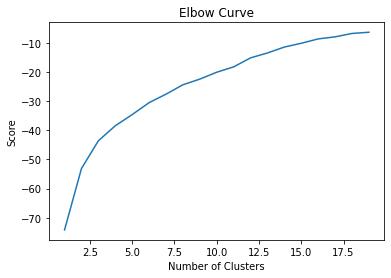

In [1050]:
#Curva del Codo
X=costa_grouped_clustering
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A partir de la gráfica anterior, se elige como mejor valor para **k=3**

In [1051]:
# establecer el número de agrupaciones
kclusters = 3

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(costa_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 0, 1, 1, 0, 1, 2])

Generemos un nuevo dataframe que incluya la agrupación asi como los 3 sitios mas populares de cada localidad.

In [1086]:
costa_localidades=costa_data[["Localidades_Costa","provincia_nombre","centroide_lat","centroide_lon"]].merge(acceso_data,left_on='Localidades_Costa', right_on='Neighbourhood')
costa_localidades=costa_localidades.drop("Neighbourhood",axis=1)
costa_localidades.head()

,Localidades_Costa,provincia_nombre,centroide_lat,centroide_lon,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo
0,Bahía Blanca,Buenos Aires,-38.713805,-62.265960,291327,SI,SI,SI,SI
1,Balneario Pehuen Co,Buenos Aires,-38.996196,-61.547199,681,SI,NO,SI,SI
2,Mar del Sur,Buenos Aires,-38.344688,-57.992039,453,SI,NO,SI,SI
3,Miramar,Buenos Aires,-38.270743,-57.840471,29433,SI,SI,SI,SI
4,Chapadmalal,Buenos Aires,-38.175778,-57.651339,4112,SI,SI,SI,SI


In [1087]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# juntar costa_grouped con costa_data 
costa_merged = costa_localidades.merge(neighborhoods_venues_sorted,left_on='Localidades_Costa', right_on='Neighbourhood')

costa_merged.head() # revisar las ultimas columnas

,Localidades_Costa,provincia_nombre,centroide_lat,centroide_lon,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bahía Blanca,Buenos Aires,-38.713805,-62.265960,291327,SI,SI,SI,SI,1,Bahía Blanca,Café,Gastropub,Burger Joint
1,Balneario Pehuen Co,Buenos Aires,-38.996196,-61.547199,681,SI,NO,SI,SI,2,Balneario Pehuen Co,Argentinian Restaurant,Campground,Golf Course
2,Mar del Sur,Buenos Aires,-38.344688,-57.992039,453,SI,NO,SI,SI,2,Mar del Sur,Breakfast Spot,Hotel,Eastern European Restaurant
3,Miramar,Buenos Aires,-38.270743,-57.840471,29433,SI,SI,SI,SI,1,Miramar,Café,Breakfast Spot,Italian Restaurant
4,Chapadmalal,Buenos Aires,-38.175778,-57.651339,4112,SI,SI,SI,SI,1,Chapadmalal,Resort,Beach,Italian Restaurant


Finalmente visualicemos las agrupaciones resultantes

In [1056]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(costa_merged['centroide_lat'], costa_merged['centroide_lon'], costa_merged['Localidades_Costa'], costa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Análisis de los Resultados 
Ahora se hace un análisis de las agrupaciones se determina las categorias del sitio que distingue a cada agrupación.

#### Agrupación 1

In [1092]:
costa_merged.loc[costa_merged['Cluster Labels'] == 0, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
13,Buenos Aires,7713,NO,SI,SI,NO,0,Santa Clara del Mar,Art Gallery,New American Restaurant,Beach
19,Buenos Aires,2081,NO,SI,SI,SI,0,Claromecó,Restaurant,Bakery,Beach
30,Río Negro,381,NO,SI,SI,SI,0,Puerto San Antonio Este,Argentinian Restaurant,Bistro,Restaurant
26,Chubut,76,NO,NO,SI,NO,0,Playa Magagna,Beach,Arcade,Lake
17,Buenos Aires,46,NO,NO,SI,SI,0,Balneario San Cayetano,Beach,Arcade,Lake


#### Agrupación 2

In [1094]:
costa_merged.loc[costa_merged['Cluster Labels'] == 1, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
5,Buenos Aires,560913,SI,SI,SI,SI,1,Mar del Plata,Café,Theater,Restaurant
0,Buenos Aires,291327,SI,SI,SI,SI,1,Bahía Blanca,Café,Gastropub,Burger Joint
24,Chubut,175196,SI,SI,SI,SI,1,Comodoro Rivadavia,Gift Shop,Supermarket,Food & Drink Shop
15,Buenos Aires,84784,SI,SI,SI,SI,1,Necochea - Quequén,Café,Italian Restaurant,Burger Joint
23,Chubut,81315,SI,SI,SI,SI,1,Puerto Madryn,Gym Pool,Arcade,Lottery Retailer
32,"Tierra del Fuego, Antártida e Islas del Atlánt...",66475,SI,SI,SI,SI,1,Río Grande,Gym,Furniture / Home Store,Gym / Fitness Center
33,Santa Cruz,51733,SI,SI,SI,NO,1,Caleta Olivia,Candy Store,Pub,Park
3,Buenos Aires,29433,SI,SI,SI,SI,1,Miramar,Café,Breakfast Spot,Italian Restaurant
7,Buenos Aires,28466,SI,SI,SI,SI,1,Mar de Ajó - San Bernardo,Café,Argentinian Restaurant,Pizza Place
16,Buenos Aires,25397,SI,SI,SI,SI,1,Pinamar,Beach,Resort,Golf Course


#### Agrupación 3

In [1095]:
costa_merged.loc[costa_merged['Cluster Labels'] == 2, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
22,Buenos Aires,29593,SI,SI,NO,SI,2,Villa Gesell,German Restaurant,BBQ Joint,Supermarket
14,Buenos Aires,6351,SI,SI,NO,SI,2,Monte Hermoso,Argentinian Restaurant,Bakery,Fast Food Restaurant
29,Río Negro,4807,SI,SI,SI,SI,2,Las Grutas,Beach,Argentinian Restaurant,Resort
21,Buenos Aires,1797,SI,NO,NO,SI,2,Mar Azul,German Restaurant,Bakery,Seafood Restaurant
12,Buenos Aires,760,NO,NO,SI,SI,2,Mar de Cobo,Plaza,Market,Arcade
28,Río Negro,746,SI,NO,SI,SI,2,El Cóndor,Argentinian Restaurant,Lake,New American Restaurant
1,Buenos Aires,681,SI,NO,SI,SI,2,Balneario Pehuen Co,Argentinian Restaurant,Campground,Golf Course
20,Buenos Aires,495,SI,NO,SI,SI,2,Reta,Argentinian Restaurant,Supermarket,Beach
11,Buenos Aires,487,SI,NO,SI,SI,2,Mar Chiquita,Restaurant,Diner,Lake
2,Buenos Aires,453,SI,NO,SI,SI,2,Mar del Sur,Breakfast Spot,Hotel,Eastern European Restaurant
